In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import math

from obspy.io.segy.core import _read_segy

from scipy import signal

import warnings
warnings.simplefilter('ignore')

#from DASLowFreqProcessing import spool,terra_io,lfproc

In [2]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx
    else:
        return idx

In [3]:
class data:
    def __init__(self):
        self.time = np.empty(0)
        self.data = np.empty(0)
        self.cutdata = np.empty(0)
        self.dist = np.empty(0)
        self.corr_data = np.empty(0)

    def read_data(self, datapath = r'C:\Users\kimki\Dropbox\2022\Field', file = './Road22side_velocity_UTC-YMD20220524-HMS202217.232_seq_00000000063.hdf5', sweepname = "5416_220524_202239_992000.sgy"):
        self.datapath = datapath
        f = h5py.File(file, 'r')

        self.dx = float(f.attrs['dx'])

        self.vel = f['velocity']
        self.time = np.array(self.vel['gps_time']).astype(np.float64)
        self.data = np.array(self.vel['data']).astype(np.float64)

        self.st = _read_segy(sweepname)

        self.sweep_starttime = datetime.datetime.fromisoformat(str(self.st[0].stats.starttime)[0:-1])
        self.sweep_endtime = datetime.datetime.fromisoformat(str(self.st[0].stats.endtime)[0:-1])

        self.starttime = datetime.datetime.fromisoformat(f.attrs['file_start_computer_time_string'][0:-1])
        self.endtime = self.starttime + datetime.timedelta(seconds = self.time[-1]-self.time[0])

        self.dist = np.arange(0, f.attrs['dx'] * f.attrs['nx'], float(f.attrs['dx']))

    def cut_data(self):
        self.buffer = self.starttime.timestamp()-self.time[0]
        lower = find_nearest(self.time, self.sweep_starttime.timestamp()-self.buffer)
        upper = find_nearest(self.time, self.sweep_endtime.timestamp()-self.buffer)

        if self.time[-1]>self.sweep_endtime.timestamp()-self.starttime.timestamp()-self.time[0]: # should be True
            self.cutdata = self.data[lower:upper]
            self.sweep = signal.resample(self.st[0].data/max(self.st[0].data), self.cutdata.shape[0])

        self.strain = (self.cutdata[:,1:] - self.cutdata[:,:-1]) / self.dx

    def correlate(self):
        self.corr_data = np.empty(self.strain.shape)
        for i in range(self.strain[0].shape[0]):
            self.corr_data[:,i] = signal.correlate(self.strain[:,i], self.sweep, mode='same')

    def plot(self, plotdata): 
        plt.figure(figsize=(5,5))
        plt.imshow(plotdata, cmap='seismic', interpolation='nearest', aspect='auto')

        plt.colorbar()

    def print_times(self):
        print(self.starttime.strftime("%A, %B %d, %Y %I:%M:%S"), self.endtime.strftime("%A, %B %d, %Y %I:%M:%S"))
        print(self.sweep_starttime.strftime("%A, %B %d, %Y %I:%M:%S"), self.sweep_endtime.strftime("%A, %B %d, %Y %I:%M:%S"))

In [4]:
class corrcoef():
    def __init__(self, data, buf = 4):
        self.buf = buf
        self.data = data
        self.init_matrix = np.empty((self.data.shape[1]-self.buf, self.buf))
        self.corr_matrix = np.empty(0)
        self.median = 0

    def matrix(self):
        for i in range(self.data.shape[1]-self.buf):
            self.init_matrix[i][0] = np.corrcoef(self.data[:,i], self.data[:,i+1])[0][1]
            for j in range(1,self.buf):
                self.init_matrix[i][j] = np.corrcoef(self.data[:,i+j], self.data[:,i+j+1])[0][1]

        self.corr_matrix = np.empty(self.init_matrix.shape[0])
        for i in range(self.init_matrix.shape[0]):
            self.corr_matrix[i] = np.median(self.init_matrix[:][i])

        self.median = np.median(self.corr_matrix)

    def stats(self):
        print(f"Mean: {np.mean(self.corr_matrix)}, median = {np.median(self.corr_matrix)}")

    def find_bad(self, thresh):
        self.bad = np.array(np.where(self.corr_matrix < thresh))
        return self.bad

    def plot_corr(self, dist):
        plt.title(f"Correlation Coefficient at buffer {self.buf}")
        plt.plot(dist[0:-self.buf], self.corr_matrix)

        plt.xlabel("Distance (m)")
        plt.ylabel("Correlation Coefficient")

        plt.show()

    def plot_hist(self):
        plt.title(f"Correlation Coefficient at buffer {self.buf}")
        plt.hist(self.corr_matrix)

        plt.xlabel("Correlation Coefficient")
        plt.ylabel("Occurences")

        plt.show()

In [5]:
DAS = data()
DAS.read_data() # put datapath, dasfile, sweepfile as arguments


In [6]:
DAS.cut_data()
DAS.correlate()

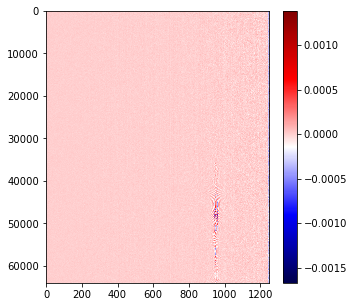

In [7]:
DAS.plot(DAS.strain)

plt.show()

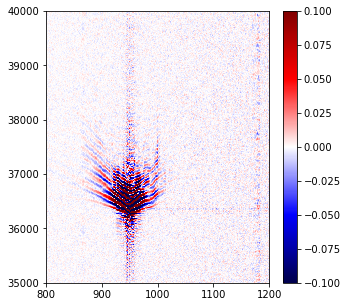

In [8]:
DAS.plot(DAS.corr_data)

plt.clim([-0.1, 0.1])
plt.ylim([35000, 40000])
plt.xlim([800,1200])

plt.show()

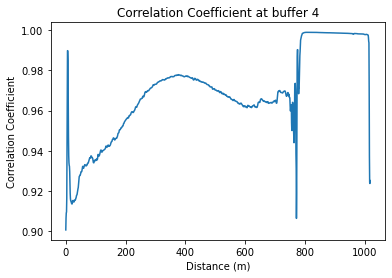

In [9]:
corr = corrcoef(DAS.cutdata)
corr.matrix()
corr.plot_corr(DAS.dist)

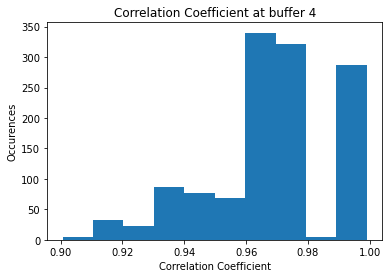

In [10]:
corr.plot_hist()

In [11]:
DAS.print_times()

Tuesday, May 24, 2022 08:22:17 Tuesday, May 24, 2022 08:23:55
Tuesday, May 24, 2022 08:22:39 Tuesday, May 24, 2022 08:22:54


In [12]:
corr.find_bad(corr.median)
print(corr.bad.shape)

(1, 624)
